In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.text import *
import numpy as np
from sklearn.model_selection import train_test_split
import pickle
import sentencepiece as spm

In [3]:
import fastai, torch
fastai.__version__ , torch.__version__

('1.0.40', '1.0.0')

In [4]:
torch.cuda.set_device(0)

In [5]:
!pwd

/home/gaurav/PycharmProjects/nlp-for-malyalam/language-model


In [6]:
path = Path('/home/gaurav/PycharmProjects/nlp-for-malyalam/language-model')

In [7]:
p = path.glob('MalyalamWikipediaArticles/*')
files = [x for x in p if x.is_file()]

In [8]:
len(files)

12388

In [9]:
train_files, test_files = train_test_split(files, test_size=0.3)

In [10]:
len(train_files), len(test_files)

(8671, 3717)

In [11]:
train_files[0]

PosixPath('/home/gaurav/PycharmProjects/nlp-for-malyalam/language-model/MalyalamWikipediaArticles/4228.pkl')

In [12]:
str(train_files[0]).split('/')[-1][:-4]

'4228'

In [14]:
# Preparing dataset for fastai
for file in train_files:
    with open(file, 'rb') as f:
        text = pickle.load(f)
    with open(path/'MalyalamDataset'/'train'/(str(file).split('/')[-1][:-4]+'.txt'), "w") as text_file:
        text_file.write(text)

In [15]:
for file in test_files:
    with open(file, 'rb') as f:
        text = pickle.load(f)
    with open(path/'MalyalamDataset'/'valid'/(str(file).split('/')[-1][:-4]+'.txt'), "w") as text_file:
        text_file.write(text)

In [16]:
class MalyalamTokenizer(BaseTokenizer):
    def __init__(self, lang:str):
        self.lang = lang
        self.sp = spm.SentencePieceProcessor()
        self.sp.Load(str(path/"../tokenizer/malyalam_lm.model"))
        
    def tokenizer(self, t:str) -> List[str]:
        return self.sp.EncodeAsPieces(t)

In [17]:
sp = spm.SentencePieceProcessor()
sp.Load(str(path/"../tokenizer/malyalam_lm.model"))
itos = [sp.IdToPiece(int(i)) for i in range(10000)]

In [18]:
# 10,000 is the vocab size that we chose in sentencepiece
malyalam_vocab = Vocab(itos)

In [19]:
tokenizer = Tokenizer(tok_func=MalyalamTokenizer, lang='ml')

In [20]:
tokenizer.special_cases

['xxunk', 'xxpad', 'xxbos', 'xxfld', 'xxmaj', 'xxup', 'xxrep', 'xxwrep']

In [21]:
data_lm = TextLMDataBunch.from_folder(path=path/'MalyalamDataset', tokenizer=tokenizer, vocab=malyalam_vocab)

In [22]:
data_lm.batch_size

64

In [23]:
data_lm.save()

In [24]:
data_lm.show_batch()

idx,text
0,▁ x x bo s ▁സംഗീത വി ദു ഷി യും ▁സാഹിത്യ കാരി യുമായിരുന്നു ▁ഇ ക്കു അ മ്മ ▁ തമ്പുരാൻ . സു ഭദ്ര ▁എന്നും ▁ഇവർ ▁അറിയപ്പെട്ട ിരുന്നു . ▁കൊച്ചി രാജ ▁കുടുംബത്തിലെ ▁അംഗ മായിരുന്ന ▁ഇ ക്കു അ മ്മ യുടെ ▁ആദ്യകാല ഗുരു ക്ക ന്മാർ ▁മൂ ഴി ക്കുളം ▁കുഞ്ഞ ുണ്ണി ▁ന മ്പി യാ രും ▁പുതിയ േ ട ത്ത് ▁ഗോവിന്ദ ൻ ▁ന മ്പി യാ രും ▁ആയിരുന്നു . നാടക ാ ലങ്കാര ങ്ങളാണ് ▁ഇവര ിൽ ▁നിന്ന് ▁അഭ്യസിച്ച
1,"▁മത ങ്ങളെ കുറ ിച്ച് ▁തീർത്ത ▁ചുമ ർ ചിത്ര ങ്ങളെ കുറ ിച്ചു മുള്ള ▁ഗി ർ ല ാൻ ഡൈ യോ യുടെ ▁കഴിവ ിനേയും , ▁പെറു ഗ് വി നോ യുടെ , ▁വിശുദ്ധ രുടേയും , മാ ലാ ഖ മാ രുടേയും ▁എല്ലാ യി പ്പോഴും , ▁പൂർണ്ണമായ ും ▁ആ ശ്ര യി ക്കാവുന്ന ▁ര മ്യ ത യേയും , നിര പര ാദി ത്വ ത്തേയും ▁വര ക്കാനുള്ള ▁കഴിവ ിനേയും ▁പ്രശംസ ിക്കുന്ന ▁സ ന്തു ഷ്ട ായ ിരിക്കുന്ന ▁ആ ശ്ര യ"
2,മല • ▁അ മല തരം • ▁അമൃത ധാര • ▁അല സ • ▁അ ലോ ല • ▁അവ നി • ▁അ ർണ്ണ ം • ▁അ ർണ്ണ വ ം • ▁അർദ്ധ കേ ക • ▁അ ശ്വ ഗതി • ▁അ ശ്വ ഗതി • ▁അ ശ്വ ല ളി തം • ▁അസ ം ബാധ • ▁ആഖ്യാന കി • ▁ആ പാത ാളി ക • ▁ആ പീഡ ം • ▁ആര്യ • ▁ആര്യ ാ ഗീത ി • ▁ഇ
3,"▁മരിച്ച പ്പോൾ , ▁ബംഗാളിലെ ▁ഭരണം ▁കമ്പനി ▁നേരിട്ട് ▁ഏറ്റെടുത്ത തായി ▁റോബർട്ട് ▁ക്ല ൈ വ് ▁പ്രഖ്യാപിച്ചു . ▁മുഗൾ ▁ചക്രവർത്തി യും ▁ബംഗാൾ ▁പ്രവിശ്യ യുടെ ▁ദിവാൻ ▁ആയി ▁കമ്പനി യെ ▁അംഗീകരിച്ച ു . ▁ഇതോടെ ▁ബംഗാൾ ▁പ്രവിശ്യ യിൽ ▁നിന്ന് ▁ലഭിക്കുന്ന ▁നികുതി വരു മാന ം ▁ഉപയോഗിച്ചു ▁തന്നെ ▁ഇന്ത്യയിൽ ▁നിന്ന് ▁സാധനങ്ങൾ ▁വാങ്ങി ▁ബ്രിട്ട ണ ിലെത്തി ക്കാൻ ▁കമ്പനി ക്കു ▁കഴിഞ്ഞു . ▁പ്ലാ സി ▁യുദ്ധ ത്തിനു ▁മുൻപ് ▁ബ്രിട്ട ണ ിൽ ▁നിന്നും ▁കൊണ്ടുവന്ന ▁സ്വർണ്ണ വും ▁വെള്ളി യും ▁ഉപയോഗിച്ചാണ് ▁കമ്പനി ▁ഇന്ത്യയിൽ ▁നിന്ന്"
4,"▁നേതാവായ ി . ▁ആ ▁നേതാവ് ▁തന്നെ പ്പോ ലൊ രുവ നെ ▁തന്റെ ▁കാൽ ▁ന ക്കാനായി ▁തെരഞ്ഞെടുക്ക ുന്നു . ▁ആ ▁സേവന ത്തിന് ▁അവ നു ▁കൊടുത്ത ിരുന്ന ▁പ്രതിഫല ം ▁ക ഴു ത മാ ം സ മായിരുന്നു . ▁കൂടുതൽ ▁ വൃത്തി കെട്ട ▁മറ്റൊരു വ നെ ▁കണ്ടു ക ിട്ടും ▁വരെ ▁അവ ൻ ▁ഈ ▁സേവന ത്തിൽ ▁തുടർന്നു . ▁സാഹിത്യ സംബന്ധിയായ ▁ലക്ഷ്യ ങ്ങള േക്കാൾ , ▁വ്യക്തി പരമായ ▁തിക ് ത ാനുഭവ ങ്ങൾ ▁മൂലം ▁വിധി ക്കും ▁മനുഷ്യ സമൂഹ"


In [25]:
len(data_lm.vocab.itos)

10000

In [26]:
learn = language_model_learner(data_lm, drop_mult=0.3)

In [27]:
gc.collect()

0

In [28]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


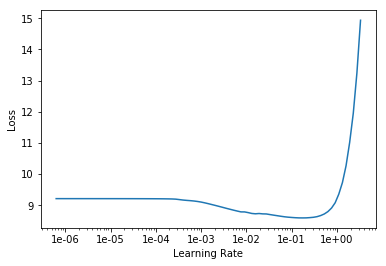

In [29]:
learn.recorder.plot()

In [30]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,5.313389,5.317996,0.192926


In [31]:
learn.save('first', with_opt=True)

In [32]:
learn.load('first', with_opt=True);

In [33]:
learn.unfreeze()

In [34]:
learn.fit_one_cycle(5, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,4.821220,4.947171,0.226521
2,4.540115,4.586594,0.260965
3,4.207016,4.262999,0.297599
4,3.762584,3.946911,0.340401
5,3.615202,3.868199,0.352610


In [35]:
learn.save('second_ml_lm', with_opt=True)

In [36]:
learn.load('second_ml_lm', with_opt=True);

In [37]:
learn.fit_one_cycle(40, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,3.639483,3.862605,0.353660
2,3.576721,3.854642,0.354983
3,3.498712,3.841652,0.356866
4,3.502330,3.824311,0.359579
5,3.529691,3.801533,0.363115
6,3.505868,3.778597,0.366981
7,3.488365,3.752562,0.371378
8,3.433761,3.722181,0.376249
9,3.494640,3.692692,0.380994
10,3.242538,3.665724,0.385454


In [38]:
learn.save('third_ml_lm', with_opt=True)

In [39]:
learn.load('third_ml_lm', with_opt=True);

In [40]:
TEXT = "ബംഗാളിലെ ▁ഭരണം ▁കമ്പനി"
N_WORDS = 40
N_SENTENCES = 2

In [41]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

ബംഗാളിലെ ▁ഭരണം ▁കമ്പനി യെ മാക്കി ക്ക ഥ ാ ഗ് വി സ ▁സമ്മാന ം ▁ ▁20 . 2 ,000 ▁ ▁പേർ ക്ക് ▁ത ങ്ങൾക്ക് ▁സ്ഥാനം ▁നല്കി ▁ആദര ിച്ചു . ▁വൈദിക - ▁പൊതു ▁- ▁മുസ്ലീം , ▁മുസ്ലീം , ▁ലത്തീൻ , ▁അധ്യാപക ൻ , ഇ ം
ബംഗാളിലെ ▁ഭരണം ▁കമ്പനി ക്ക് ▁നൽകിയ ിരുന്നു . . ജ മാ റോ യി ▁ഈ ▁ചേ ർ ച്ച് ▁ഹ ിൽ ▁ഈ ർ ഖ ൗ ▁ ത് ര ബ ത ന ൽ ▁ബി ▁അ ദി ▁ ▁ ▁ ത്ത് ▁ ▁സ് ▁കൂ ▁കേ . ▁ ▁സാധ


In [42]:
np.exp(3.273)

26.39039188081262